In [1]:
import time
import random
import math
import itertools

In [2]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import gym
from gym.envs.registration import register

In [3]:
class QTable:
    def __init__(self, num_states, num_actions, alpha=0.002, gamma=0.8):
        """
        `alpha`: learning rate

        `gamma`: discount factor
        """
        self.num_states = num_states
        self.num_actions = num_actions
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount factor
        # Initialize Q table with 0
        self.q_table = np.zeros((num_states, num_actions), dtype=np.float)

    def update_table(self, state, action, reward, new_state):
        current_q_value = self.q_table[state, action]
        target_q_value = reward + self.gamma * np.max(self.q_table[new_state])
        delta = self.alpha * (target_q_value - current_q_value)
        self.q_table[state, action] += delta

    def get_next_action(self, state):
        return np.argmax(self.q_table[state])

### Register an un-slippery version of `FrozenLake`

It's easier to get started with the un-slippery environment.

In [4]:
register(
    id='FrozenLakeNotSlippery-v0',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name': '4x4', 'is_slippery': False},
)

In [5]:
env_name = 'FrozenLakeNotSlippery-v0'
# env_name = 'FrozenLake-v0'

env = gym.make(env_name)
env.render()


SFFF
FHFH
FFFH
HFFG


In [6]:
#==========Create a q-table==========#
num_states = env.observation_space.n
num_actions = env.action_space.n
q_table = QTable(num_states, num_actions)


# set the percent you want to explore
EPS_START = 1.0
EPS_END = 0.2
EPS_DECAY = 10_000

Run this cell to train the agent (can be re-run multiple times)

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 39685.77it/s]


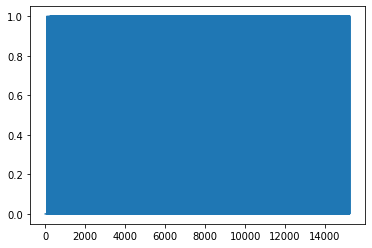

In [15]:
num_steps = 100_000
reward_log = []

state = env.reset()
eps_reward = 0

for step in tqdm(range(num_steps)):
    #==========Taking action: Explore or Exploit==========#
    sample = random.random()
    eps_threshold = EPS_END + max(0, (EPS_START - EPS_END) * (EPS_DECAY - step) / EPS_DECAY)
    if sample < eps_threshold:
        # Explore: select a random action
        action = random.randrange(num_actions)
    else:
        # Exploit: select the action with max value (future reward)
        action = q_table.get_next_action(state)

    next_state, reward, done, info = env.step(action)

    #==========Updating the q-table==========#
    q_table.update_table(state, action, reward, next_state)
    eps_reward += reward
    
    if done:
        state = env.reset()
        reward_log.append(eps_reward)
        eps_reward = 0
    else:
        state = next_state

reward_log = np.array(reward_log)
plt.plot(reward_log)
# x = np.array(list(range(len(reward_log))))
# plt.plot(x, reward_log, 'ro')

## Test Q-table (the `agent`)

In [16]:
q_table.q_table

array([[2.61826369e-01, 3.27680000e-01, 2.06537183e-01, 2.61807970e-01],
       [2.61301369e-01, 0.00000000e+00, 2.18695708e-02, 1.01698434e-01],
       [8.65137214e-02, 1.43295522e-02, 2.96774698e-04, 6.83963139e-03],
       [4.52428355e-03, 0.00000000e+00, 1.08934368e-04, 9.95422157e-05],
       [3.26523772e-01, 4.09600000e-01, 0.00000000e+00, 2.61213771e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.13942399e-01, 0.00000000e+00, 2.87874095e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.07248607e-01, 0.00000000e+00, 5.12000000e-01, 3.25624257e-01],
       [4.04273255e-01, 6.40000000e-01, 6.22488160e-01, 0.00000000e+00],
       [2.16244815e-01, 7.99582916e-01, 0.00000000e+00, 3.57840904e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 6.29386818e-01, 8.00000000e

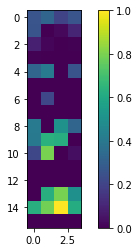

In [17]:
plt.imshow(q_table.q_table)
plt.colorbar()

## Visualize our agent grid world

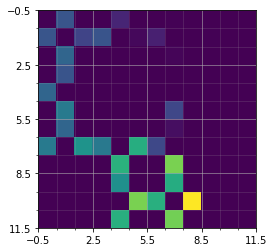

In [18]:
# number of rows and cols of the world
rows = 4
cols = 4

# each cell has a square 3x3 to store up, down, left and right
# so that we can visualize which action the agent is going to take
display_grid = np.zeros((rows * 3, cols * 3), dtype=np.float32)
for row in range(rows):
    for col in range(cols):
        state = row * rows + col
        grid_cell = np.zeros((3, 3), dtype=np.float32)
        # left
        grid_cell[1, 0] = q_table.q_table[state][0]
        # down
        grid_cell[2, 1] = q_table.q_table[state][1]
        # right
        grid_cell[1, 2] = q_table.q_table[state][2]
        # top
        grid_cell[0, 1] = q_table.q_table[state][3]
        
        display_grid[
            row * 3: (row+1) * 3,
            col * 3: (col+1) * 3
        ] = grid_cell

# add grid overlay to our plot
# https://stackoverflow.com/a/24953575/8364403
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(display_grid, cmap='viridis')

# major_ticks = np.arange(0, 12+1, 3)
# minor_ticks = np.arange(0, 12+1, 1)
major_ticks = np.arange(-0.5, 12, 3)
minor_ticks = np.arange(-0.5, 12, 1)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)

ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.7)

In [28]:
state = env.reset()
env.render()


SFFF
FHFH
FFFH
HFFG


Run this `cell` repeatedly to see how the agent does in the environment.

In [34]:
obs = env.step(q_table.get_next_action(state))
print(obs)

new_state, reward, done, info = obs
state = new_state
env.render()

(15, 1.0, True, {'prob': 1.0})
  (Right)
SFFF
FHFH
FFFH
HFFG
